Internal qa


Plan is to pull in scenario files then make a bunch of outputs 

THen render this as an html 

We will work on MAIN files for now and just pull in every scenario in the repo

However, down the line we have scope to a) adjust where we are pulling data from (i would prefer the GDXs but should align with outputs generally) and b) set up some user choice mechanism for which scenarios we read and where they are read from. Ideally all the results for different scenarios and scenario versions should be in a db somewhere. 


In [5]:
# libraries 
import pandas as pd
import numpy as np
import re
import os 
from pathlib import Path


import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
# pull data 
# not portable please fix
# assuming the wd will be of wherever this is pulled from but not yet sure of structure
TIMES_LOCATION = os.path.join("C:/Users/searlel/repos", "TIMES-NZ-MODEL-FILES")

# there is also the issue that the tui/kea scenario structure is hardcoded in a bit, but really we need to generalise scenarios and versions 

# so the options appear to be the gdx files or this big dumb vd file 
# is it wrong that i prefer the gdx? does it match? 
TIMES_OUTPUTS_GDX = os.path.join(TIMES_LOCATION, "TIMES-NZ-GAMS", "GAMSSAVE")
TIMES_OUTPUTS_RAW = os.path.join(TIMES_LOCATION, "TIMES-NZ-GAMS", "times_scenarios")
TIMES_OUTPUTS_PROCESSED = os.path.join(TIMES_LOCATION, "TIMES-NZ-OUTPUT-PROCESSING", "data", "output")


gdx_files = os.listdir(TIMES_OUTPUTS_GDX)
raw_files = os.listdir(TIMES_OUTPUTS_RAW)
processed_files = os.listdir(TIMES_OUTPUTS_PROCESSED)

# bunch of extra stuff in here for now until we know what we're doing and can clean up a bit 




In [125]:
def combine_versioned_tables(directory, table_type='main'):
    """
    Reads and combines CSV files containing a specific table type from a directory, adding version information.
    
    Parameters:
    directory (str): Path to directory containing CSV files
    table_type (str): Type of table to process (e.g., 'main', 'clean', 'raw')
    
    Returns:
    pandas.DataFrame: Combined dataframe with version information
    """
    # Convert directory to Path object for better handling
    dir_path = Path(directory)
    
    # Get all CSV files in directory
    file_list = list(dir_path.glob('*.csv'))
    
    if not file_list:
        raise ValueError(f"No CSV files found in directory: {directory}")
    
    # Filter for files containing the specified table type
    relevant_files = [f for f in file_list if f'_{table_type}_' in f.name]
    
    if not relevant_files:
        raise ValueError(f"No files found containing '{table_type}'")
    
    # Initialize empty list to store dataframes
    dfs = []
    
    # Process each file
    for file_path in relevant_files:
        # Extract version using regex
        version_match = re.search(r'v(\d+)_(\d+)_(\d+)', file_path.name)
        if version_match:
            major, minor, patch = version_match.groups()
            version_string = f"{major}.{minor}.{patch}"
            
            print(f"Processing {file_path.name}...")
            
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Add version information
            #df['version_major'] = int(major)
            #df['version_minor'] = int(minor)
            #df['version_patch'] = int(patch)
            # df['version_string'] = version_string
            df["Scenario"] = df["Scenario"] + " v" + version_string
            #df['source_file'] = file_path.name
            
            dfs.append(df)
    
    # Combine all dataframes
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        raise ValueError("No valid files were processed")

In [127]:
# currently set up to just take every version of main 
# NOTE that individual tables are currently setup to always be kea + tui 
# really this needs to be generalised much further to allow for any scenario combinations at all 
# so we might need to break down output methods to allow for this 
main_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED)
clean_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED, table_type = "clean")
raw_df = combine_versioned_tables(TIMES_OUTPUTS_PROCESSED, table_type = "raw")

Processing output_main_df_v2_1_2.csv...
Processing output_main_df_v2_1_3.csv...
Processing output_clean_df_v2_1_2.csv...
Processing output_clean_df_v2_1_3.csv...
Processing output_raw_df_v2_1_2.csv...


C:\Users\SearleL\AppData\Local\Temp\ipykernel_6988\4139935449.py:41: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Processing output_raw_df_v2_1_3.csv...


C:\Users\SearleL\AppData\Local\Temp\ipykernel_6988\4139935449.py:41: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


## Emissions

Text(50.70762152777776, 0.5, 'Mt CO2')

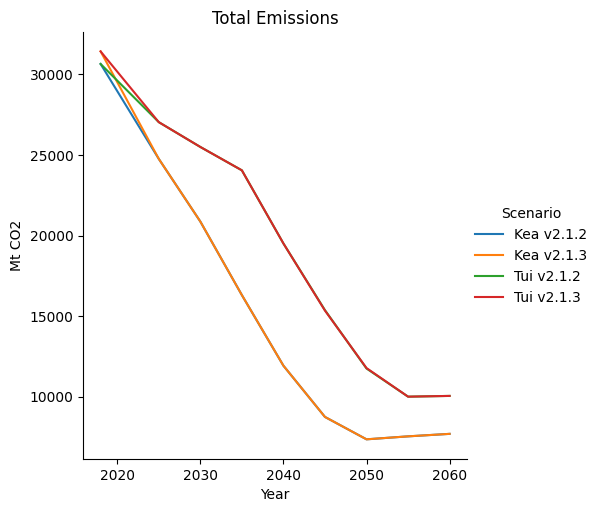

In [130]:
 # hey you need to think about how you do your data a bit better here this feels messy

def aggregate_emissions_data(df, group_cols):
    df = df[df["CommoditySet"] == ".ENV."]
    df = df.groupby(group_cols).sum("Value").reset_index()
    # df["Value"] = df["Value"]/1000
    # df["Unit"] = "Mt CO2"
    return df

emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters"]

chart_data = aggregate_emissions_data(main_df, emissions_group_cols_agg)
#unit = chart_data["Unit"].unique()

sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
)
plt.title("Total Emissions")
plt.xlabel("Year")
plt.ylabel("Mt CO2")# not co2e??
 


## Emissions by fuel

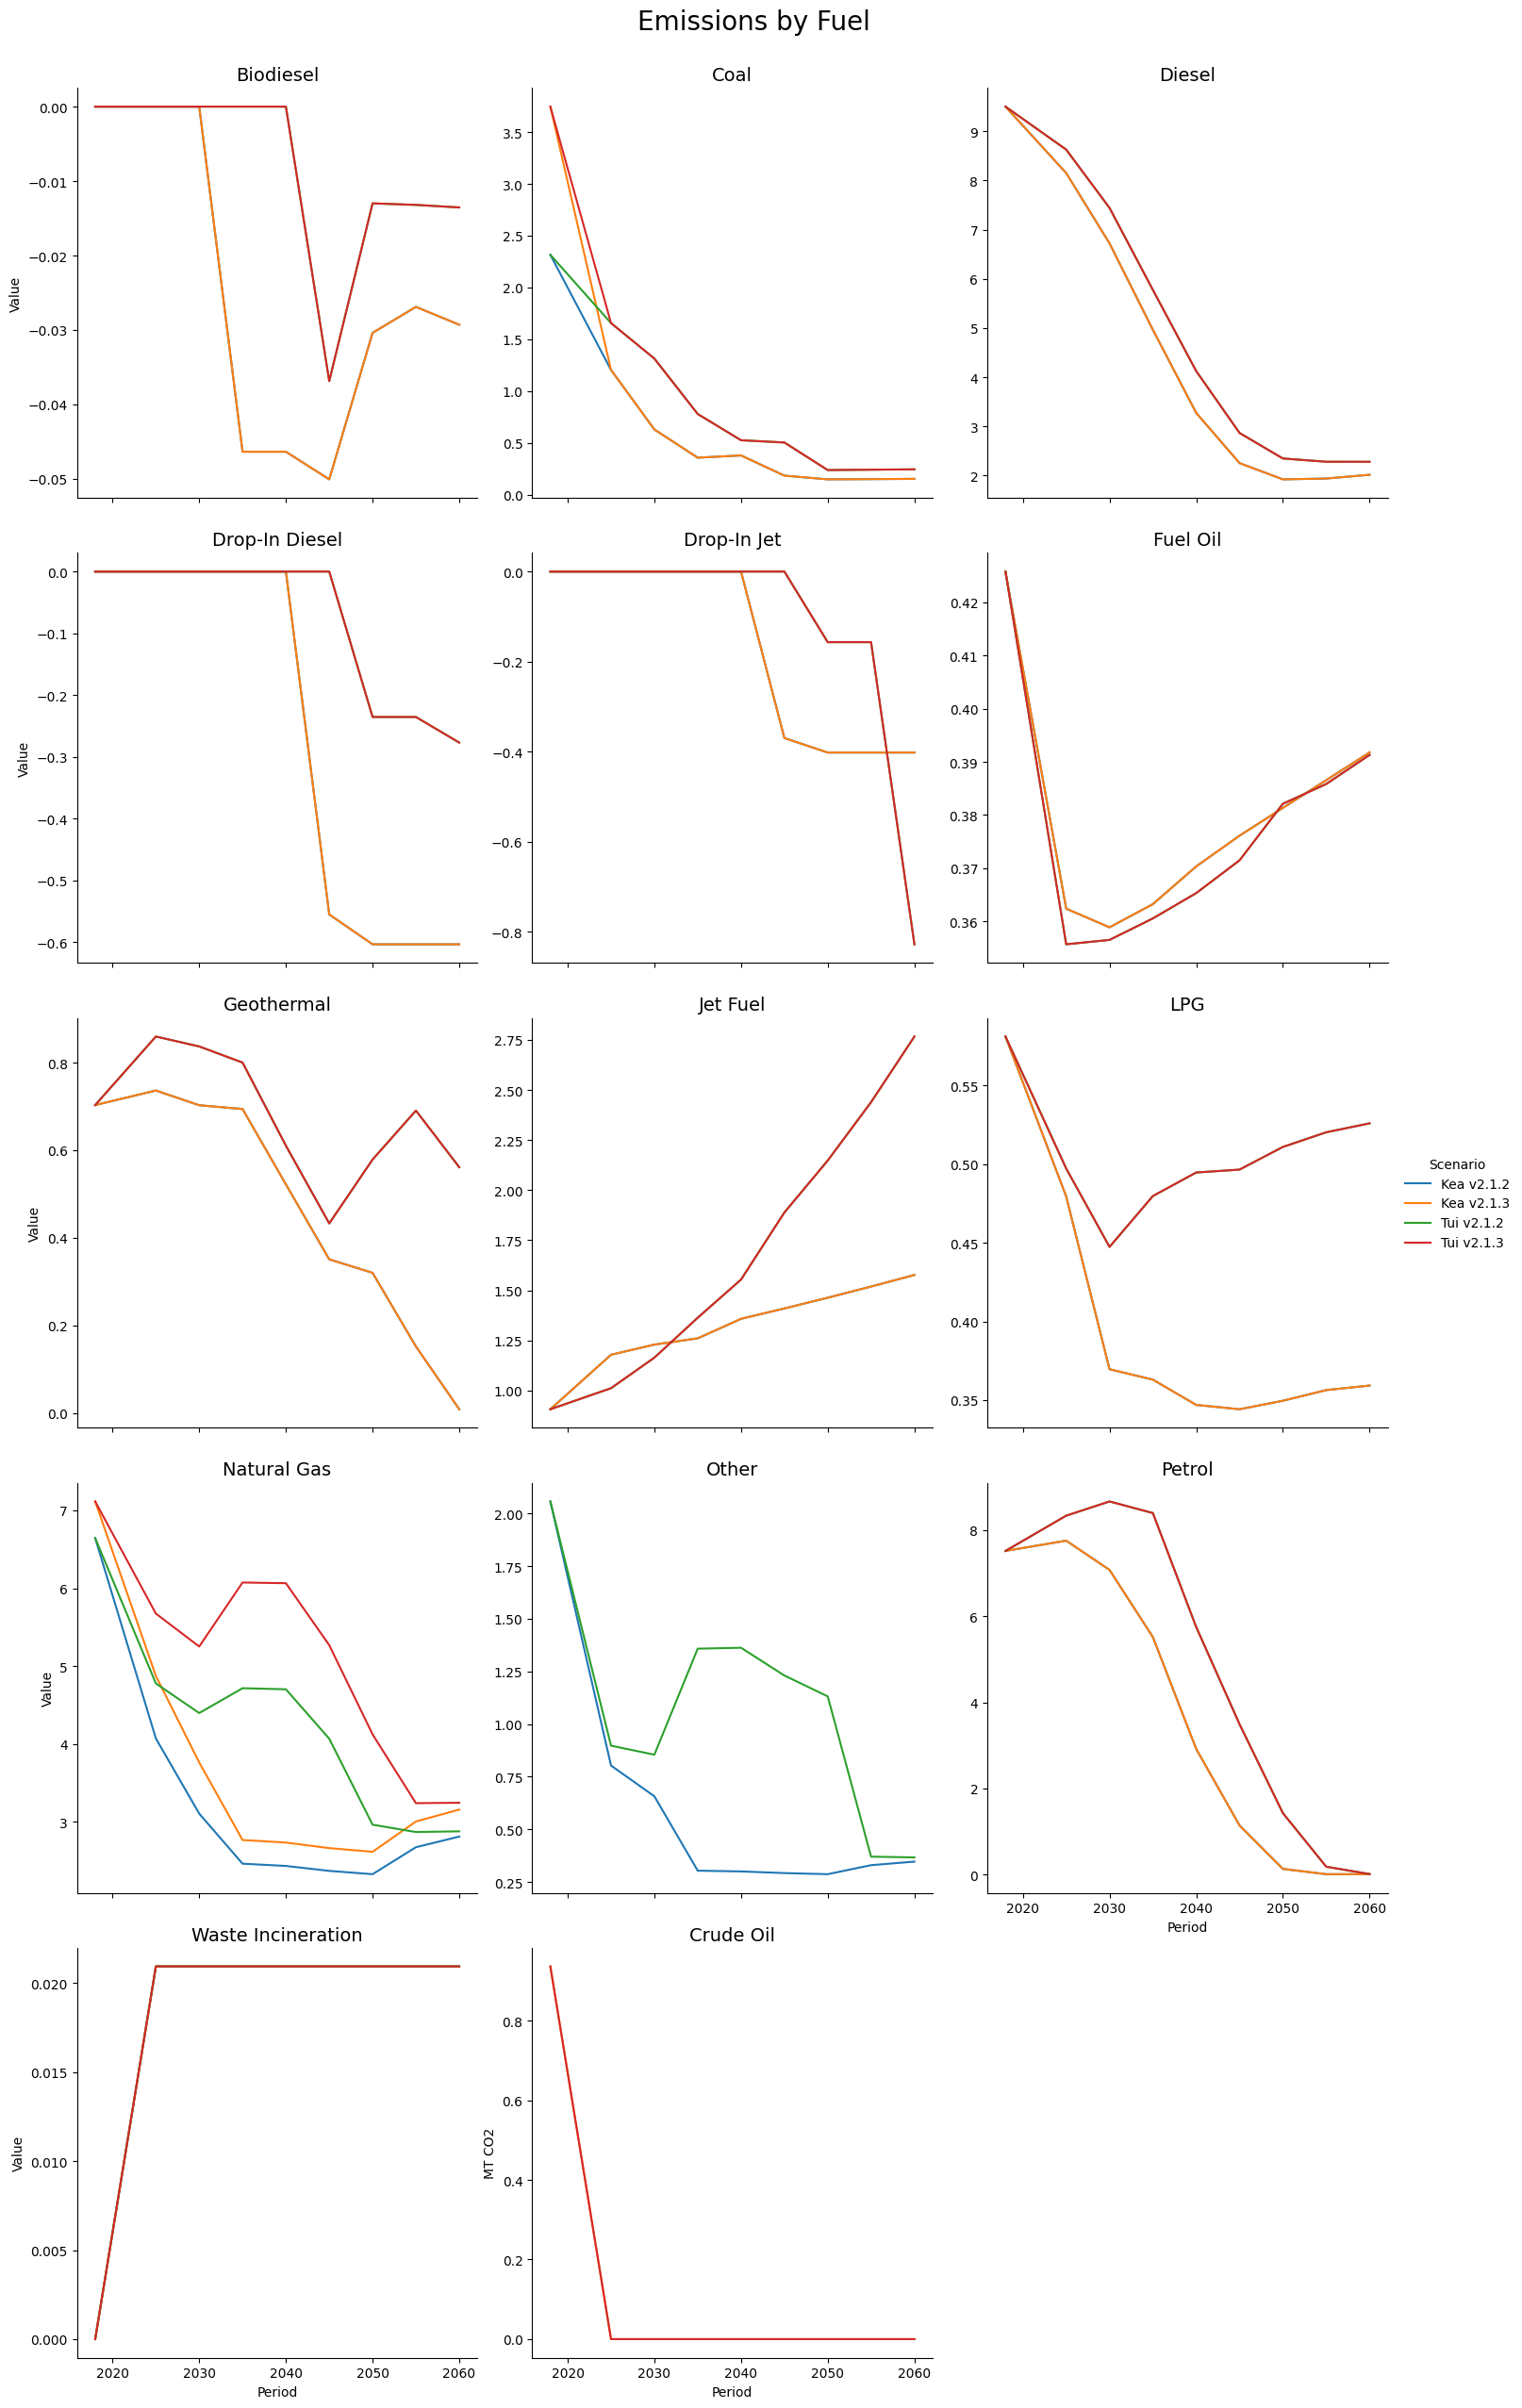

In [131]:

emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters", "Fuel"]
chart_data = aggregate_emissions_data(clean_df, emissions_group_cols_agg)


# chart_data
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Fuel", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Fuel", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("MT CO2")

g

## Emissions by Sector

Text(38.69030092592593, 0.5, 'MT CO2')

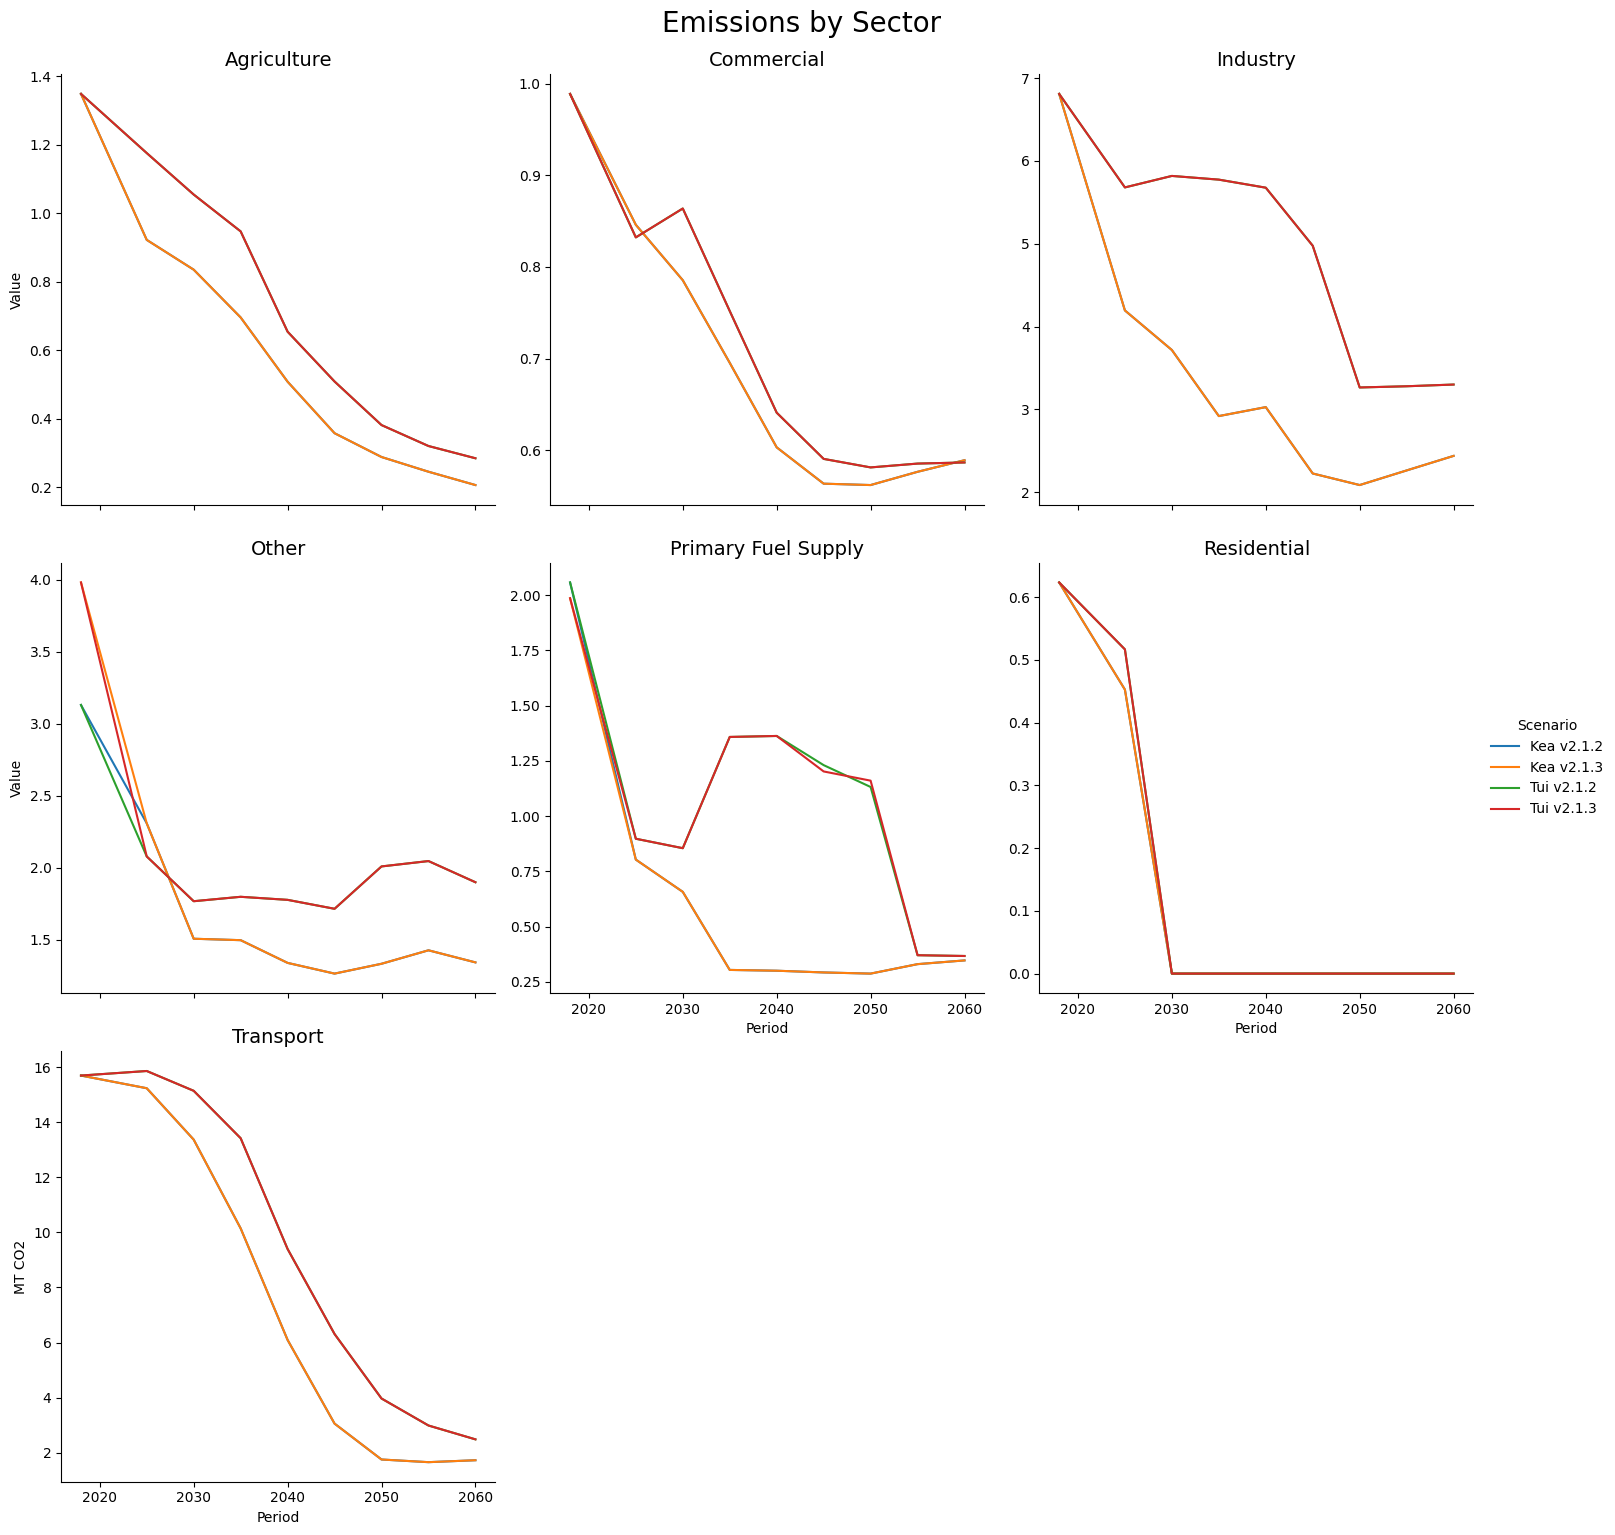

In [117]:
emissions_group_cols_agg = ["Scenario", "Period", "Unit", "Parameters", "Sector"]
chart_data = aggregate_emissions_data(clean_df, emissions_group_cols_agg)

# chart_data
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Emissions by Sector", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel("MT CO2")

## Supply

In [ ]:
clean_df

## End Use

Text(557.0751929012333, 0.5, "['PJ']")

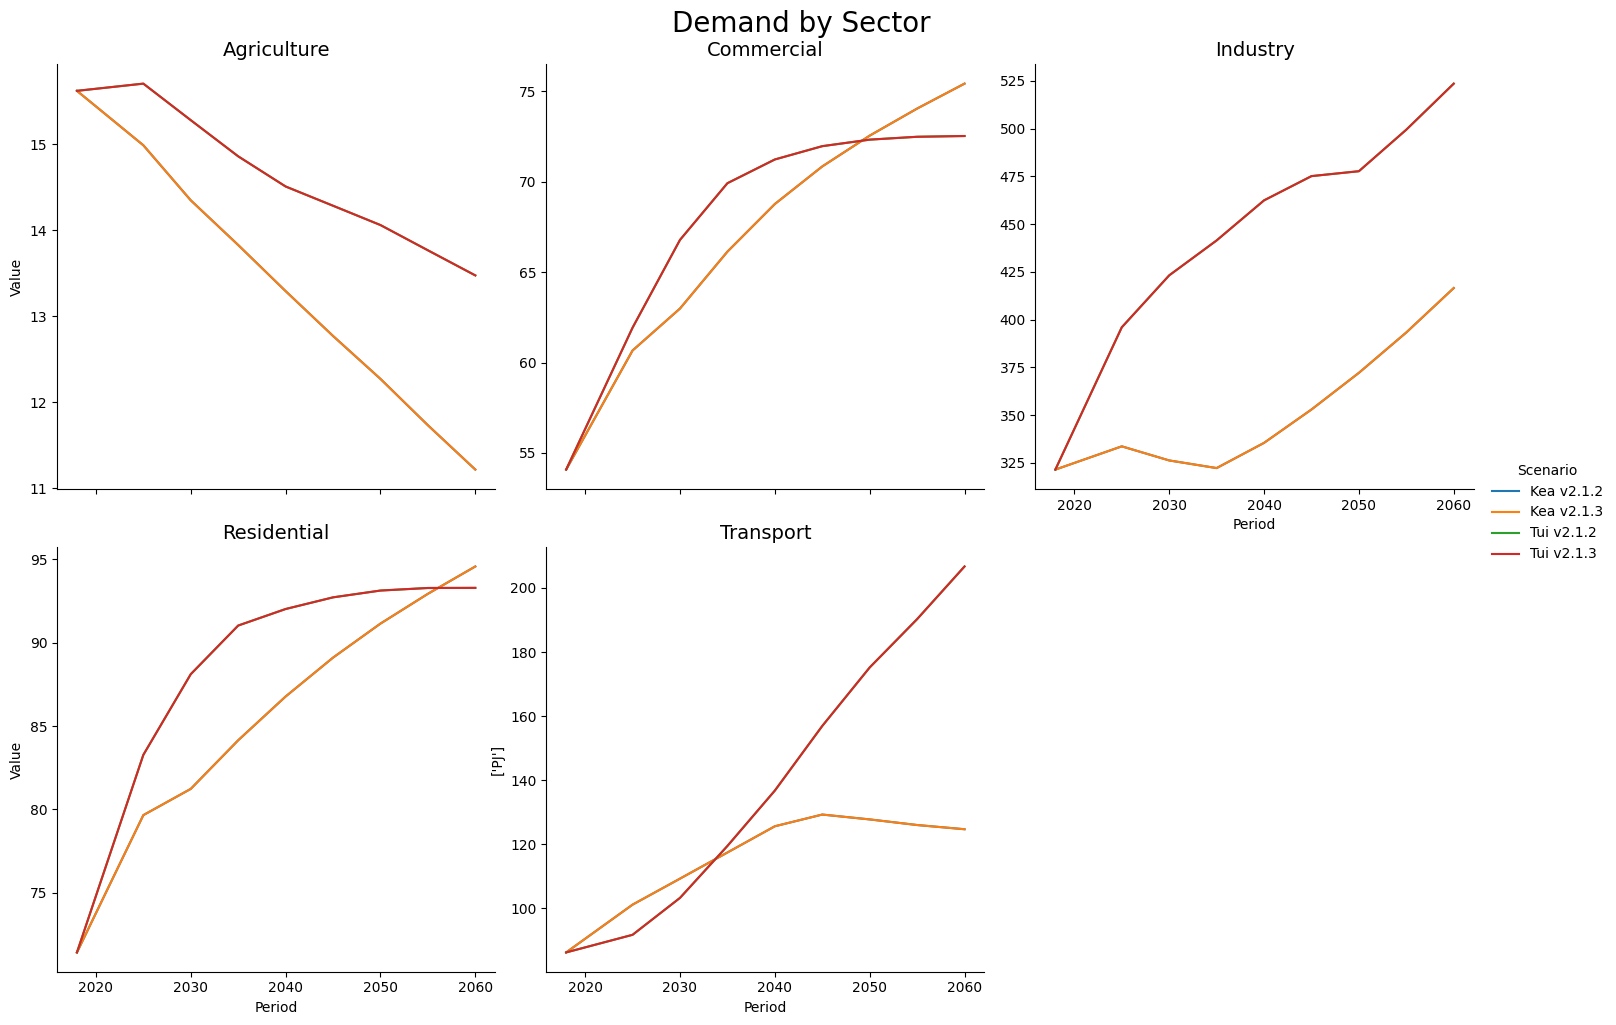

In [116]:
clean_df.head()

def aggregate_demand_data(df, group_cols):
    df = df[df["Parameters"] == "End Use Demand"]
    df = df.groupby(group_cols).sum("Value").reset_index()    
    return df


demand_group_cols = ["Scenario", "Period", "Sector", "Unit"]

chart_data = aggregate_demand_data(clean_df, demand_group_cols)

unit = chart_data["Unit"].unique()
g = sns.relplot(
    data = chart_data, 
    x = "Period", y = "Value", hue = "Scenario",
    kind = "line",
    col = "Sector", 
    col_wrap = 3,
    facet_kws={'sharey': False}
)
g.figure.suptitle("Demand by Sector", y = 1.02, size = 20)
g.set_titles(col_template="{col_name}", size = 14)
plt.ylabel(unit)



## Agriculture

## energy demand? 

## technology use? 



In [115]:
def make_sector_demand_chart(sector, facet_variable, df = clean_df):
    demand_cols = ["Scenario", "Period", "Sector", "Unit", facet_variable]    

    chart_data = aggregate_demand_data(df, demand_cols)
    chart_data = chart_data[chart_data["Sector"] == sector]

    unit = chart_data["Unit"].unique()[0]

    g = sns.relplot(
        data = chart_data, 
        x = "Period", y = "Value", hue = "Scenario",
        kind = "line",
        col = facet_variable,         
        col_wrap = 4,
        facet_kws={'sharey': False}
        )
    
    g.figure.suptitle(f"{sector} energy demand by {facet_variable}", y = 1.05, size = 20)
    g.set_titles(col_template="{col_name}", size = 14)
    g.set_axis_labels("Year", unit)   


def make_sector_tech_x_fuel_chart(sector, df = clean_df):

    demand_cols = ["Scenario", "Period", "Sector", "Unit", "Technology_Group", "Fuel"]   

    chart_data = aggregate_demand_data(df, demand_cols)
    
    chart_data = chart_data[chart_data["Sector"] == sector]

    unit = chart_data["Unit"].unique()[0]

    g = sns.relplot(
        data = chart_data, 
        x = "Period", y = "Value", hue = "Scenario",
        kind = "line",
        col = "Technology_Group",         
        row = "Fuel",
        # col_wrap = 4,
        facet_kws={'sharey': False}
        )
    
    g.figure.suptitle(f"{sector} energy demand", y = 1.05, size = 20)
    g.set_titles(col_template="{col_name}", size = 14)
    g.set_axis_labels("Year", unit)   
    

def make_sector_demand_charts(sector):
    for variable in ["Fuel", "Subsector", "Technology_Group"]:
        make_sector_demand_chart(sector, variable)
    # make_sector_tech_x_fuel_chart(sector)



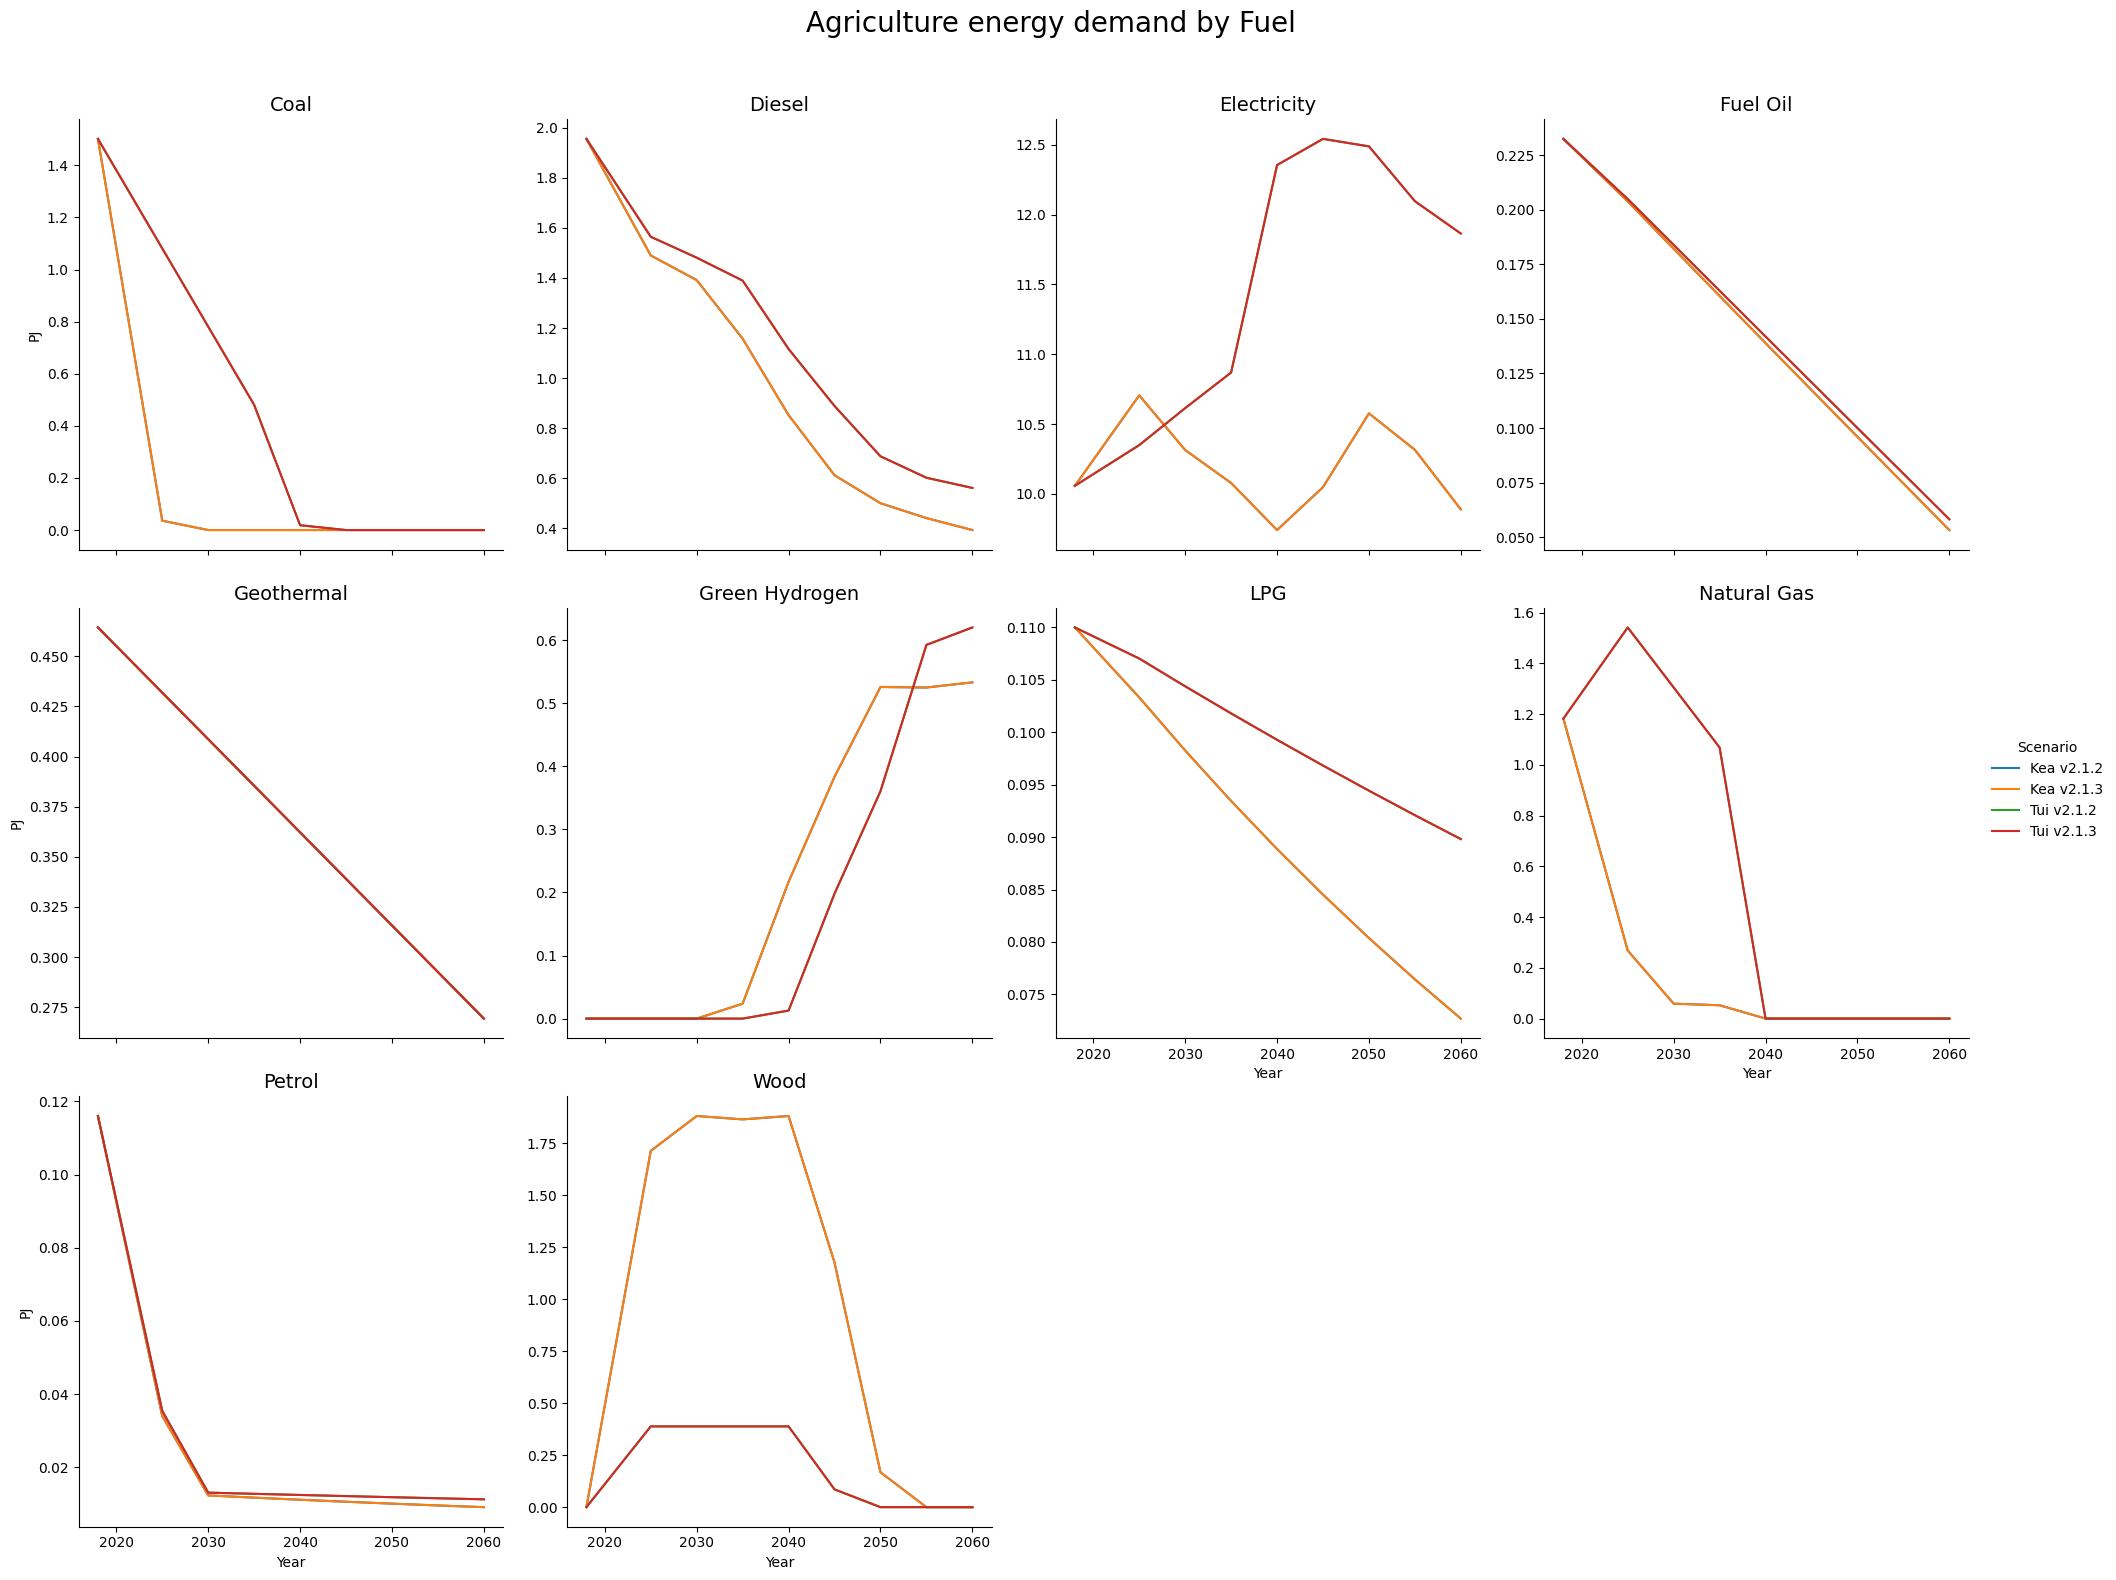

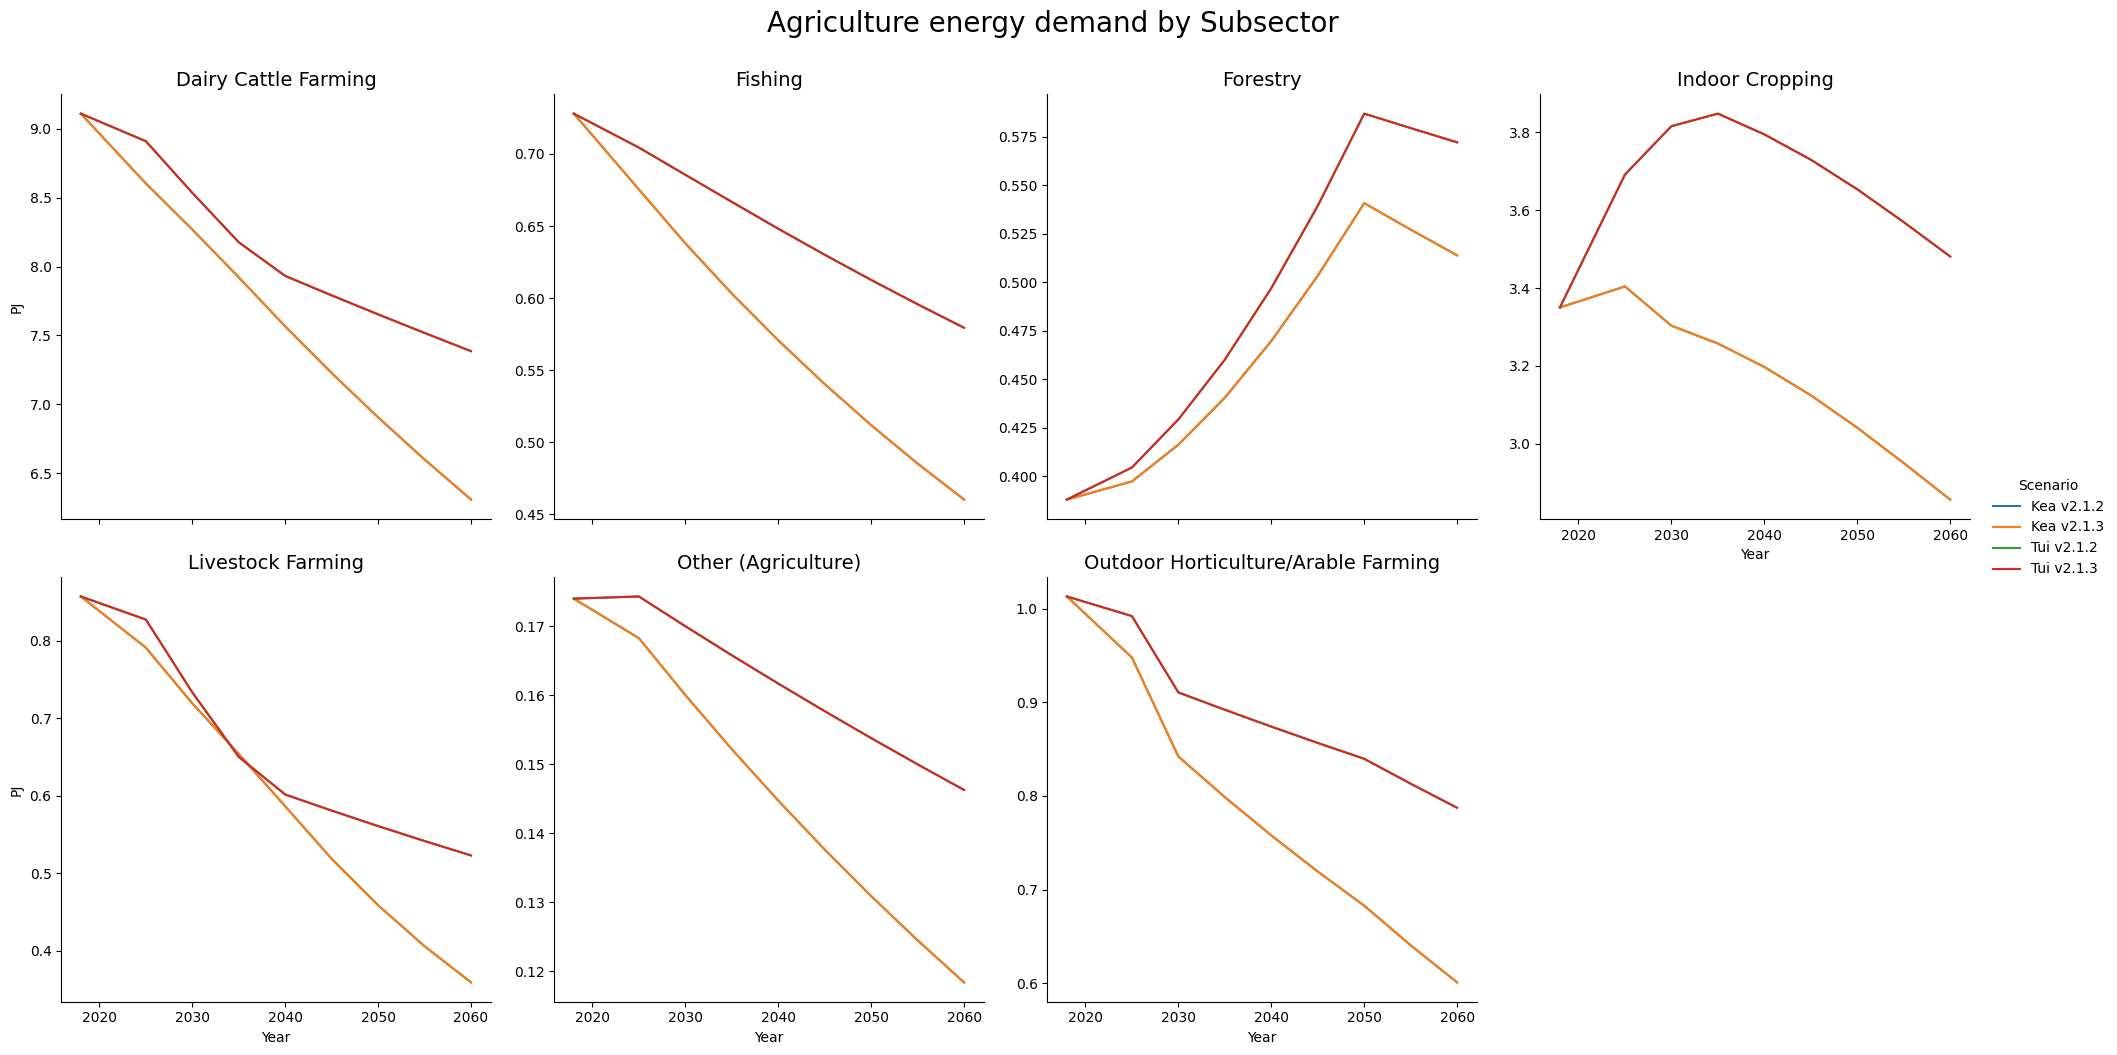

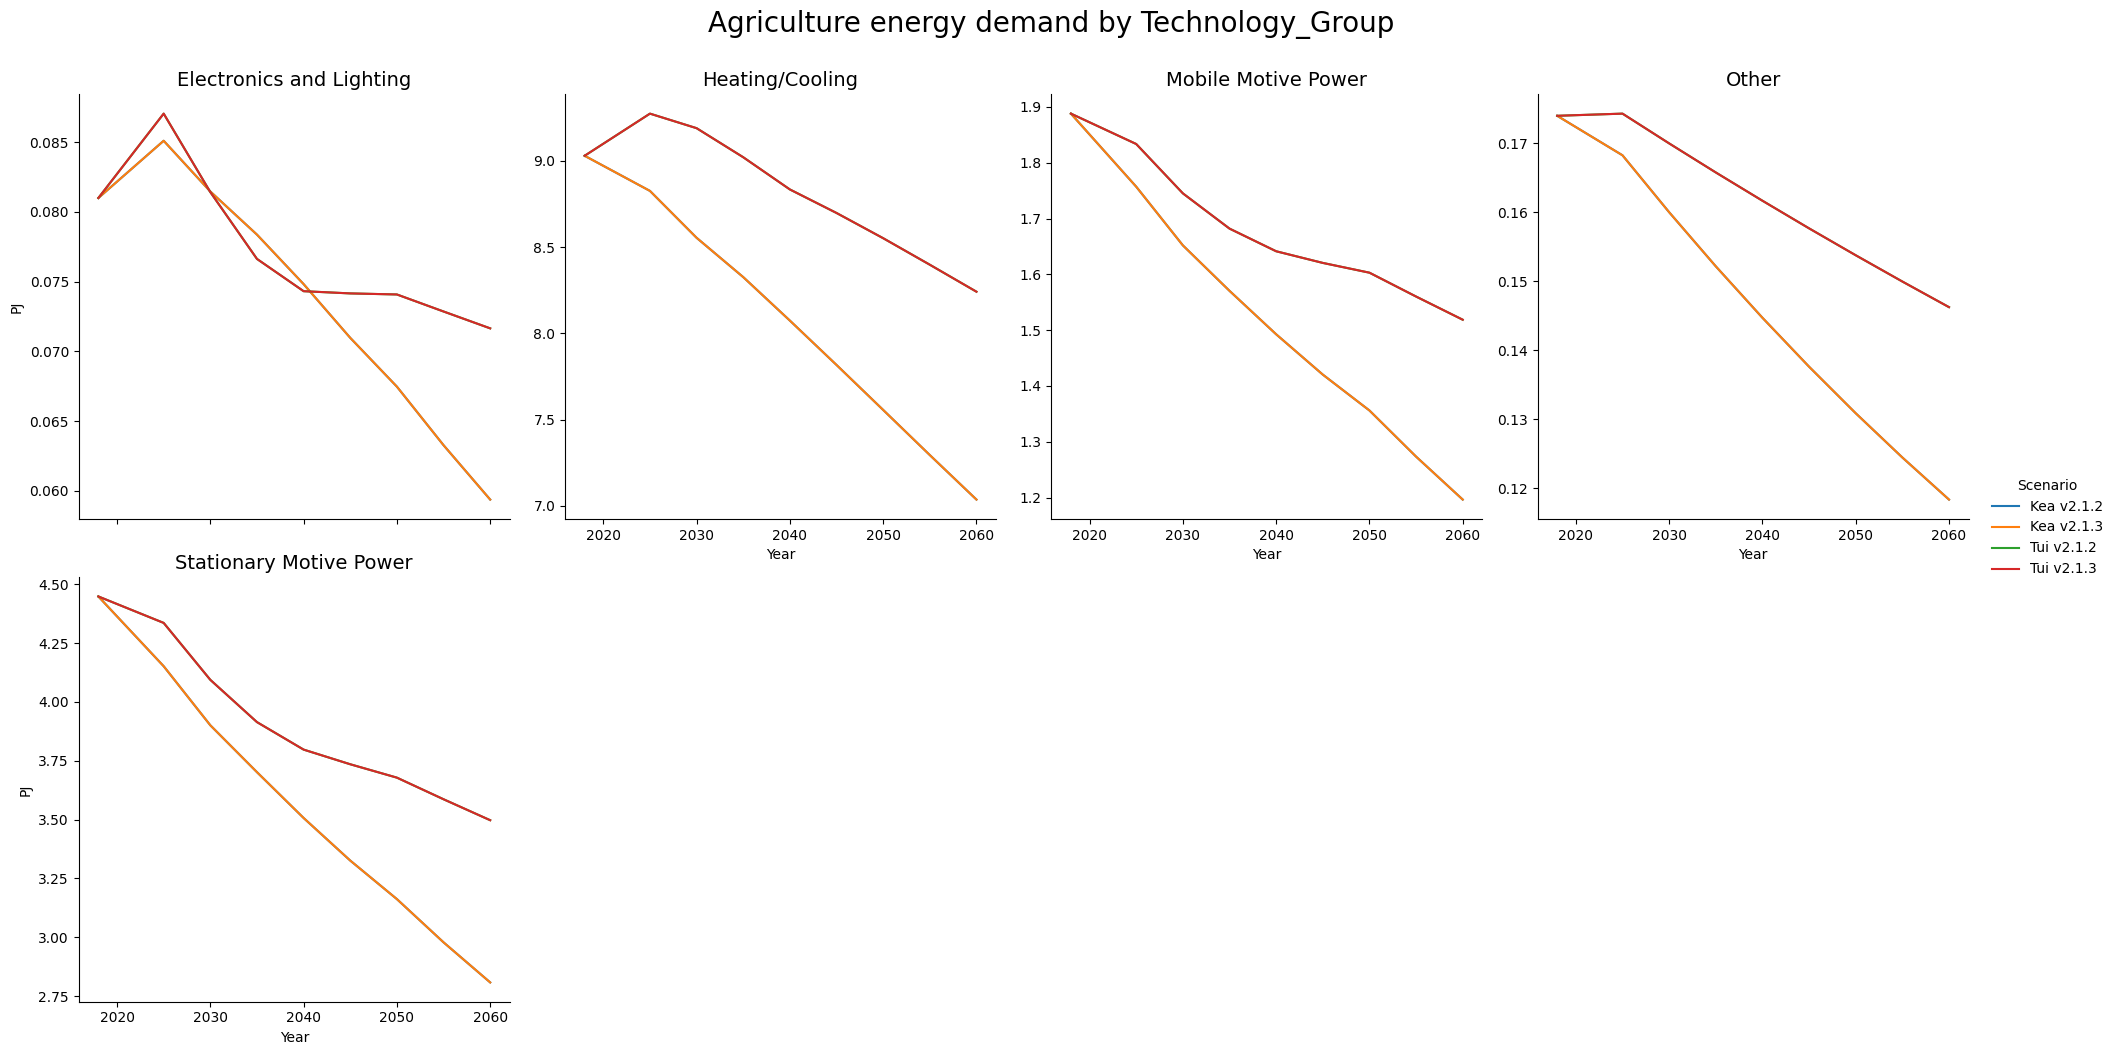

In [121]:
make_sector_demand_charts("Agriculture")

In [ ]:
make_sector_demand_charts("Industry")

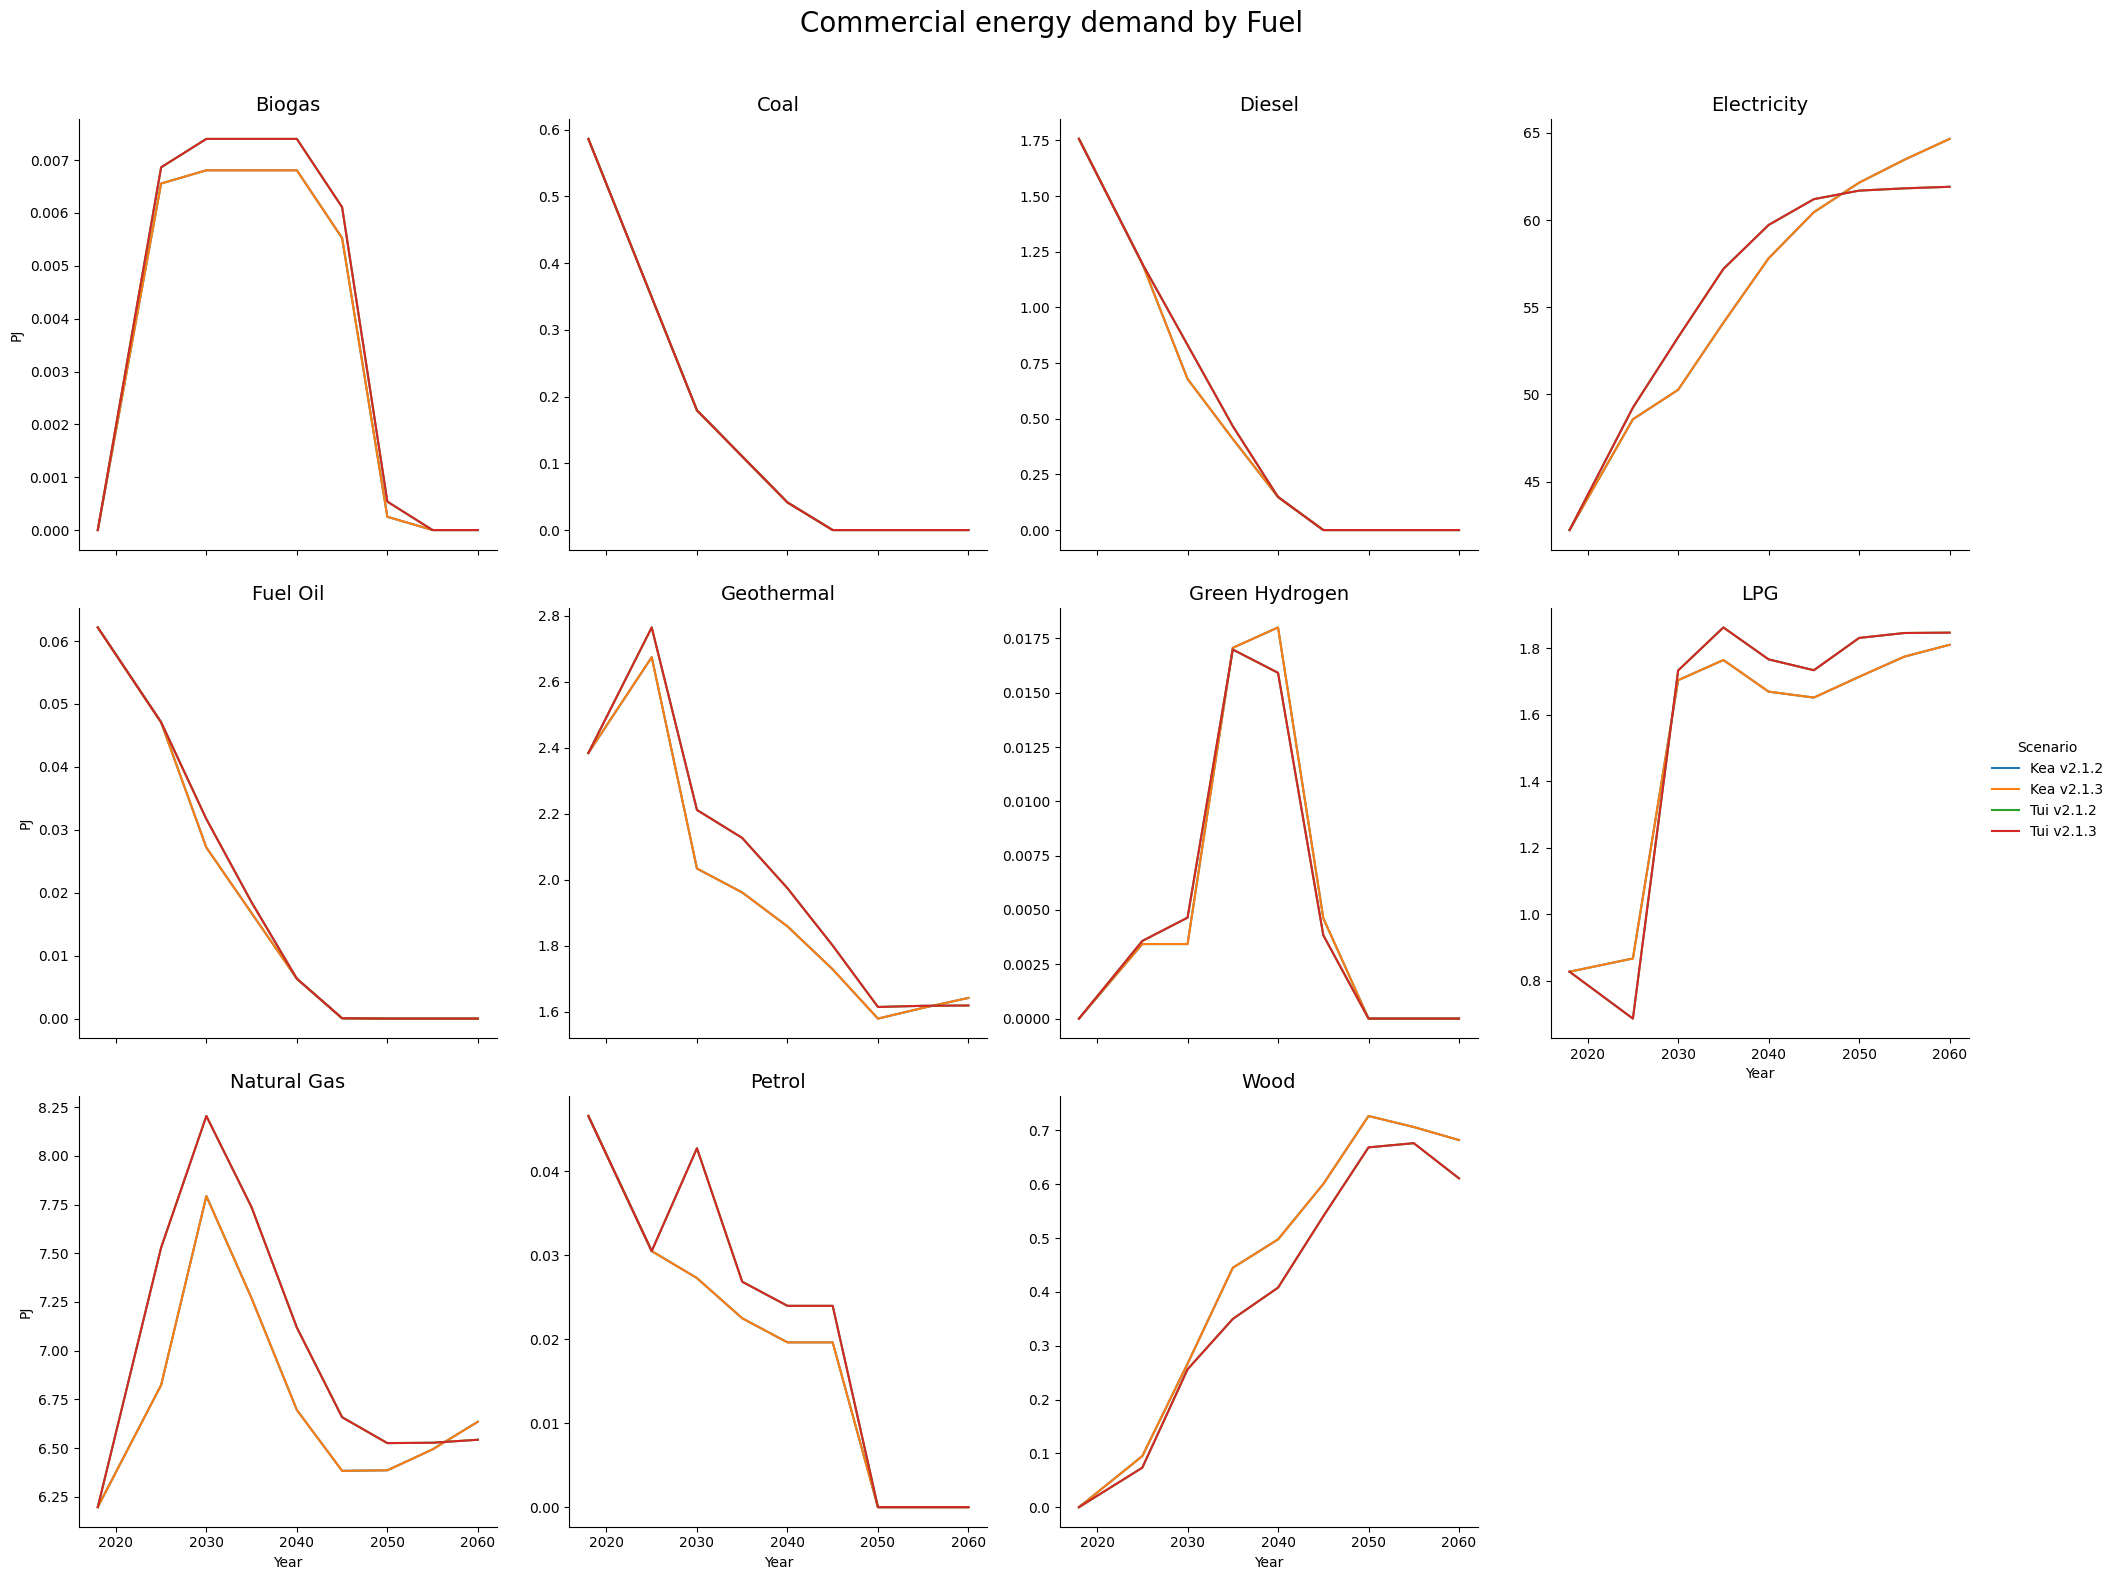

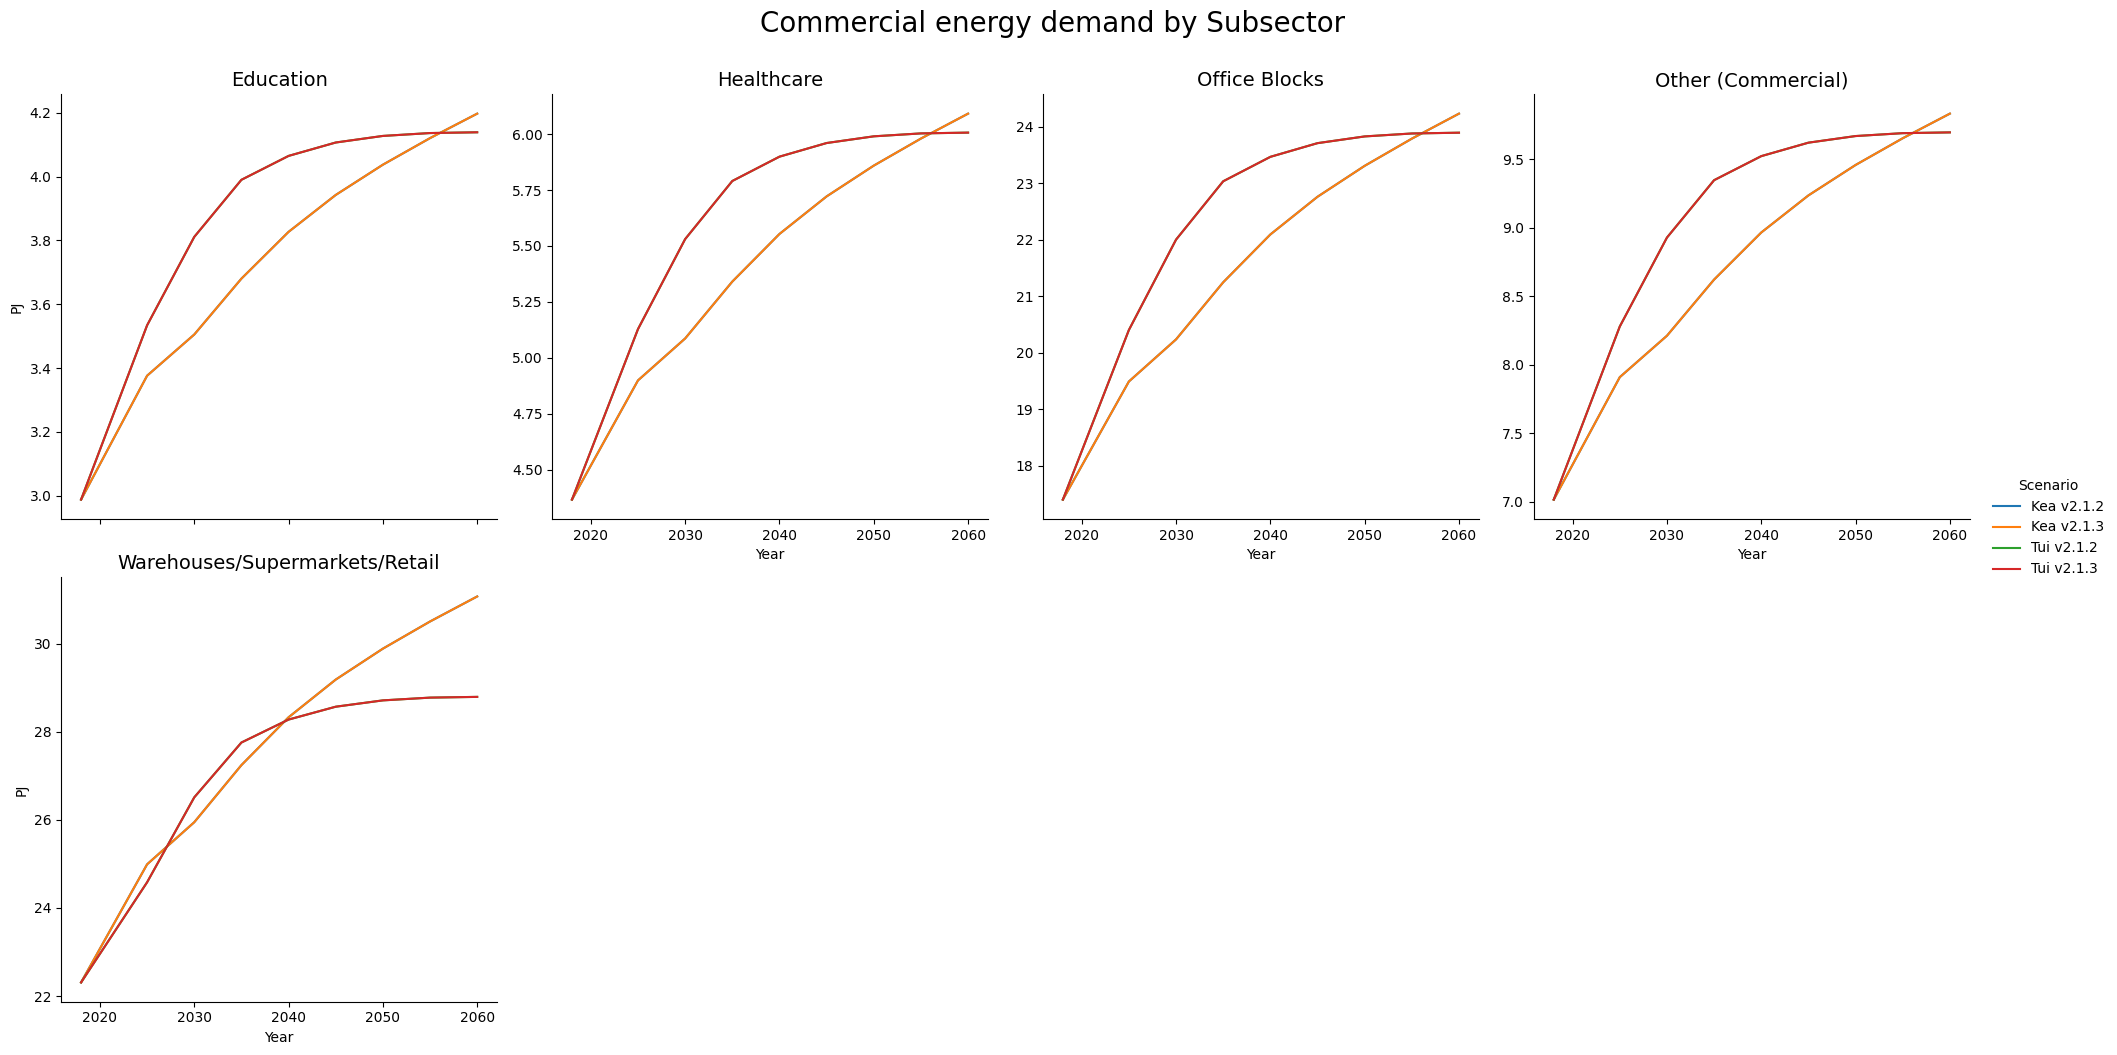

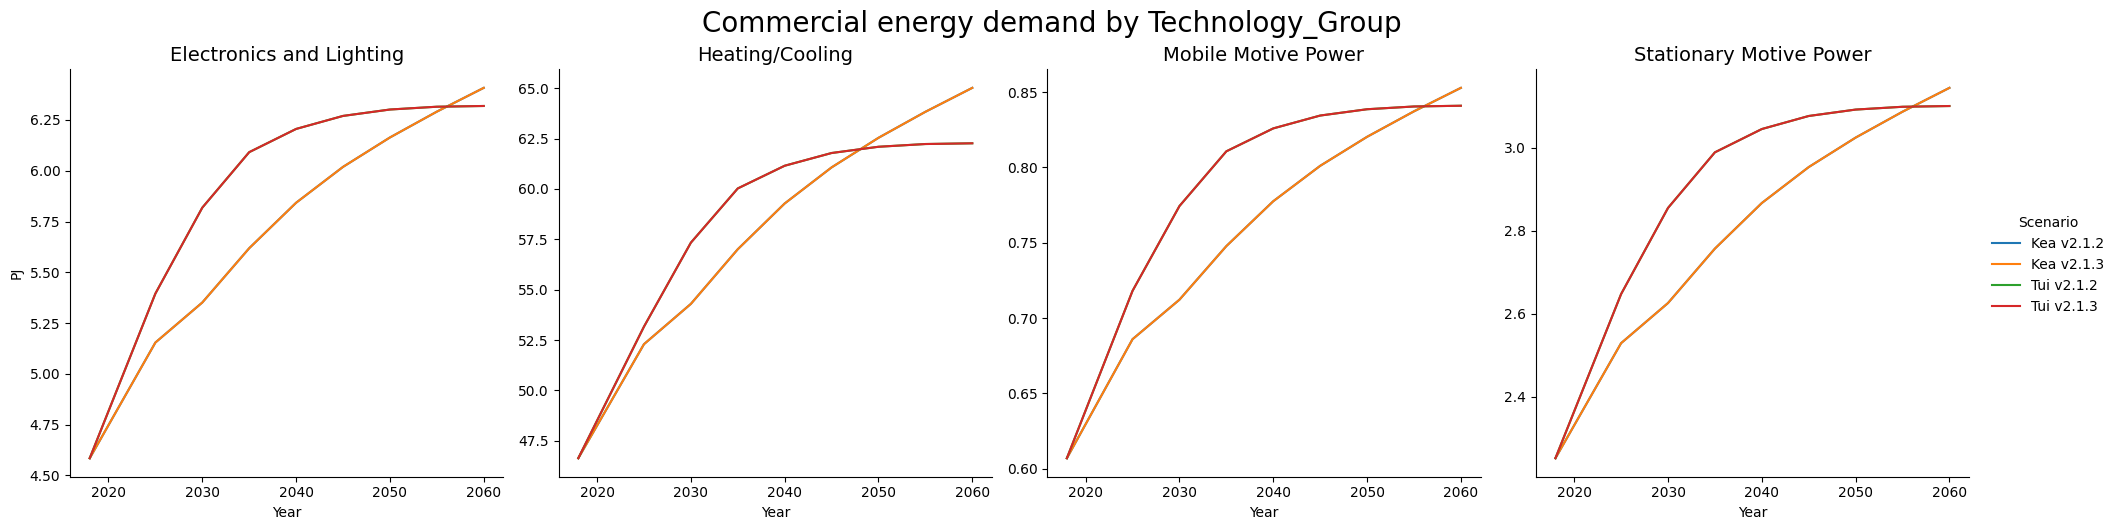

In [122]:
make_sector_demand_charts("Commercial")

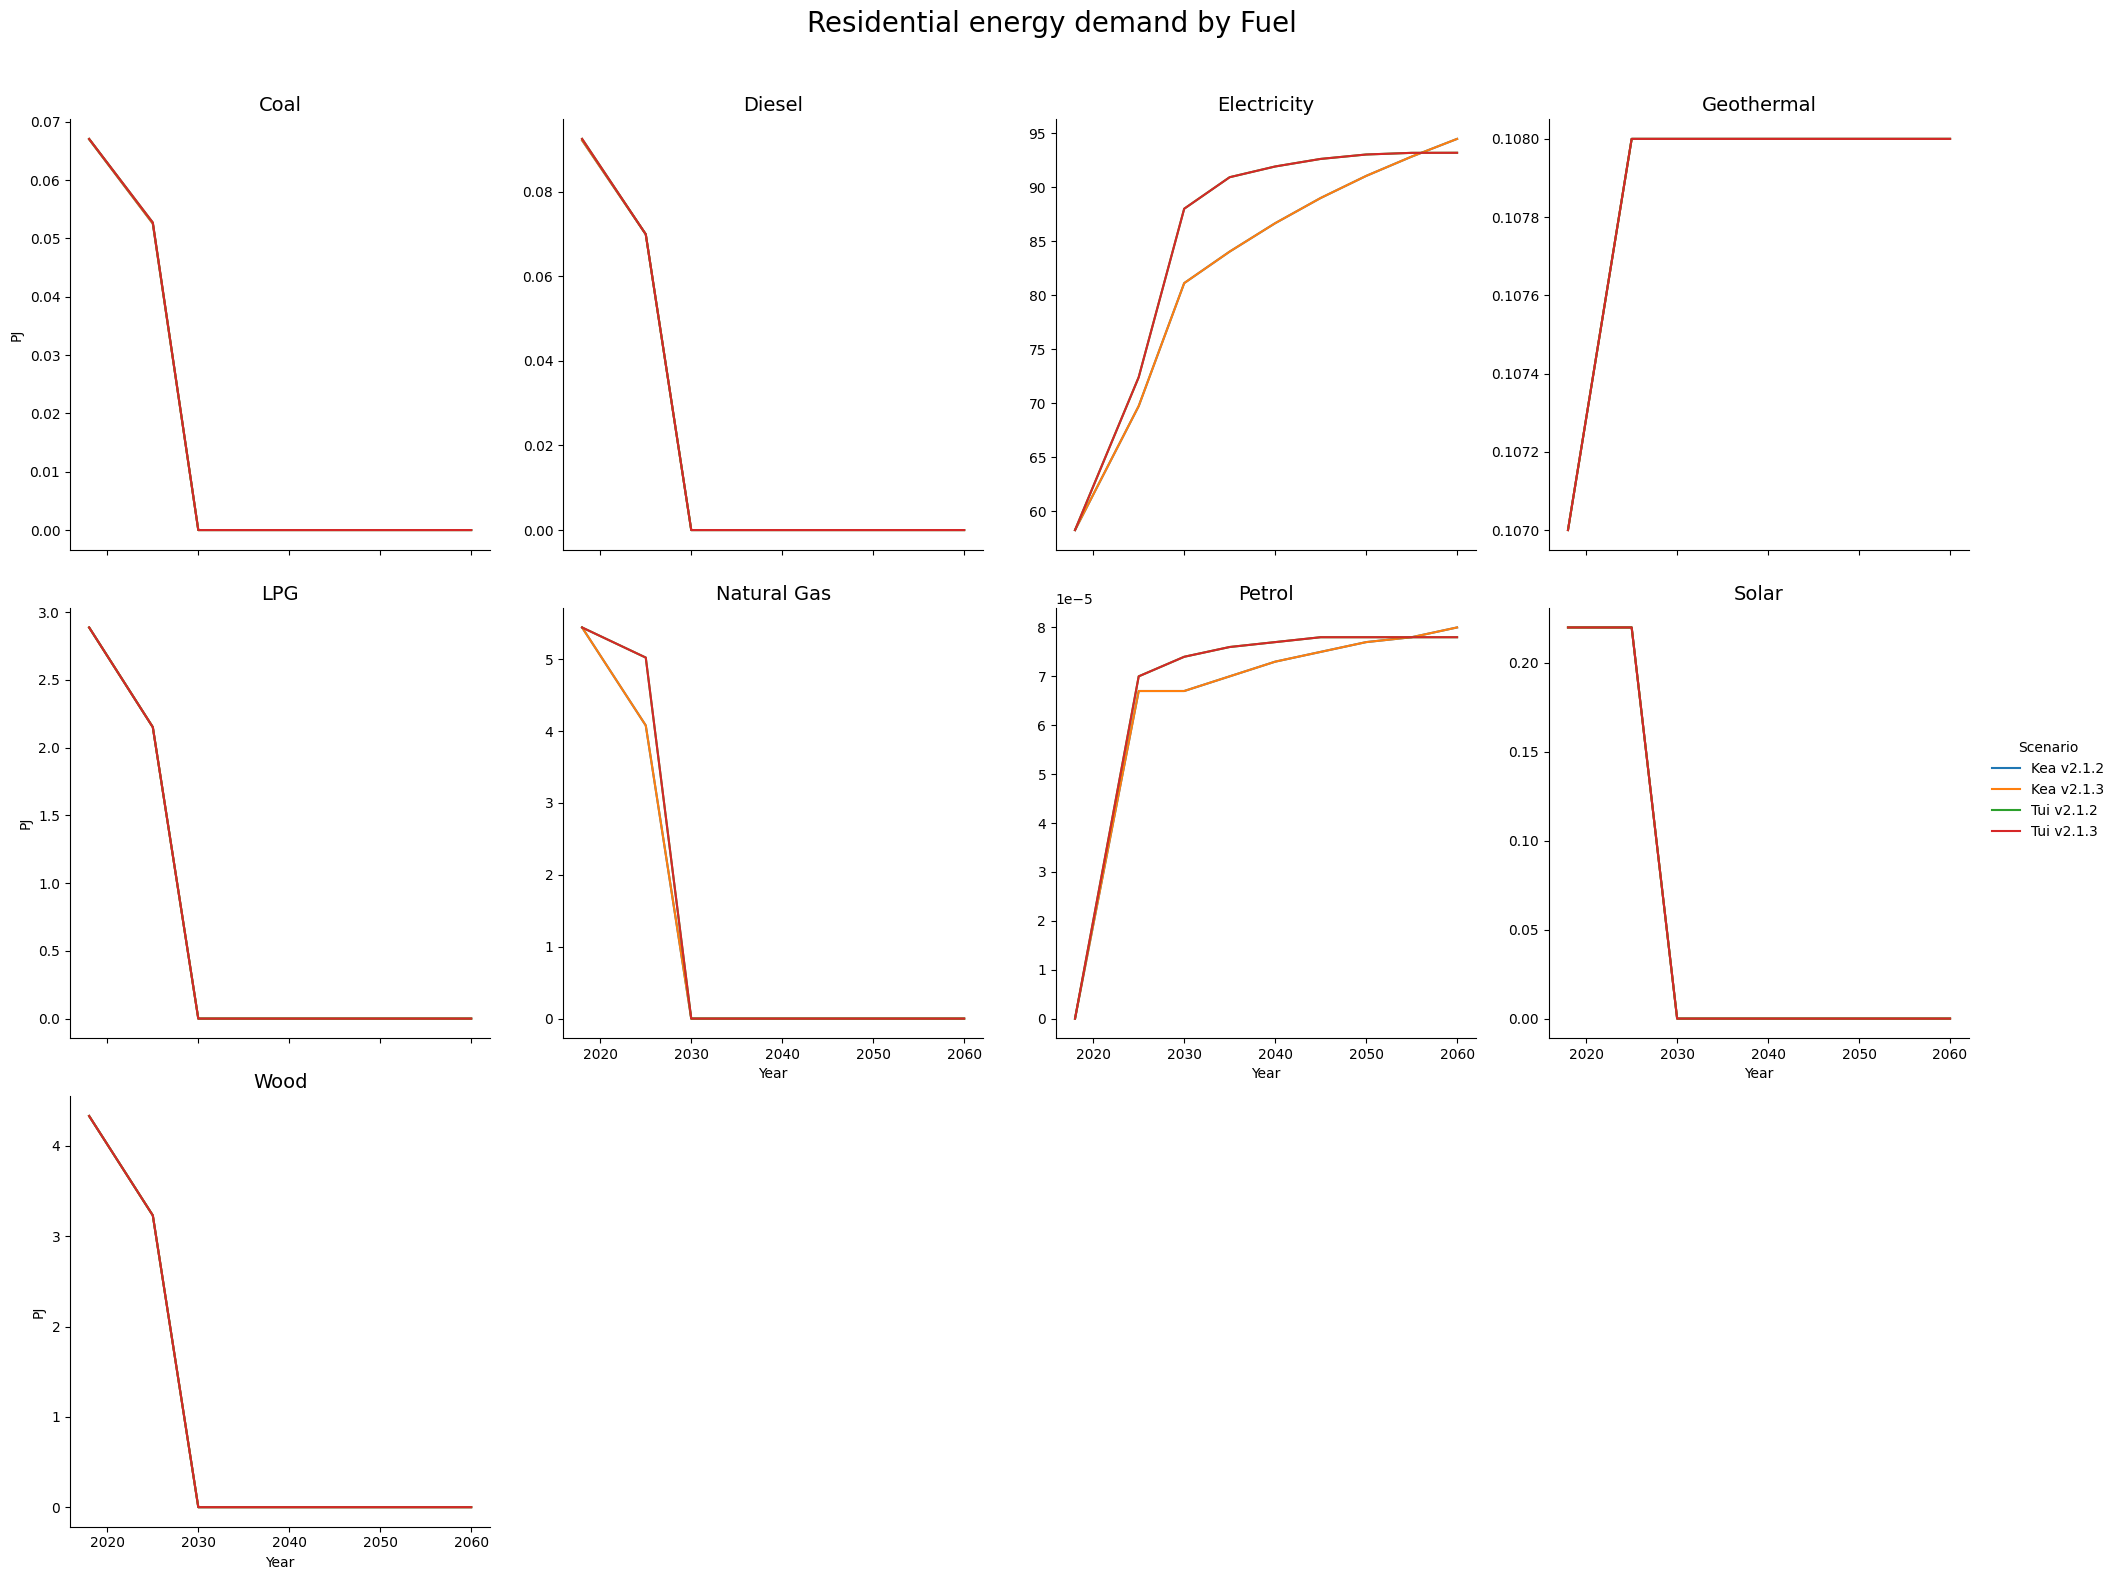

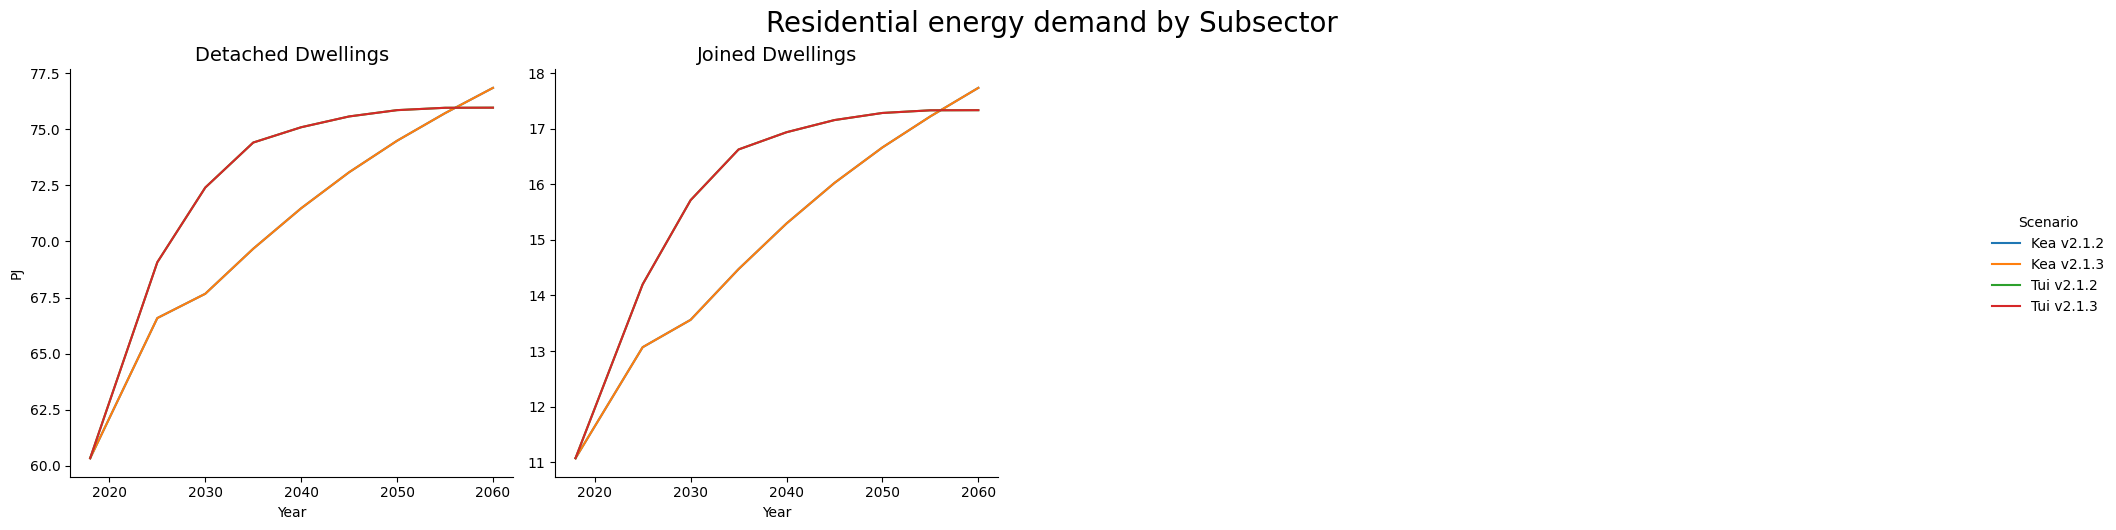

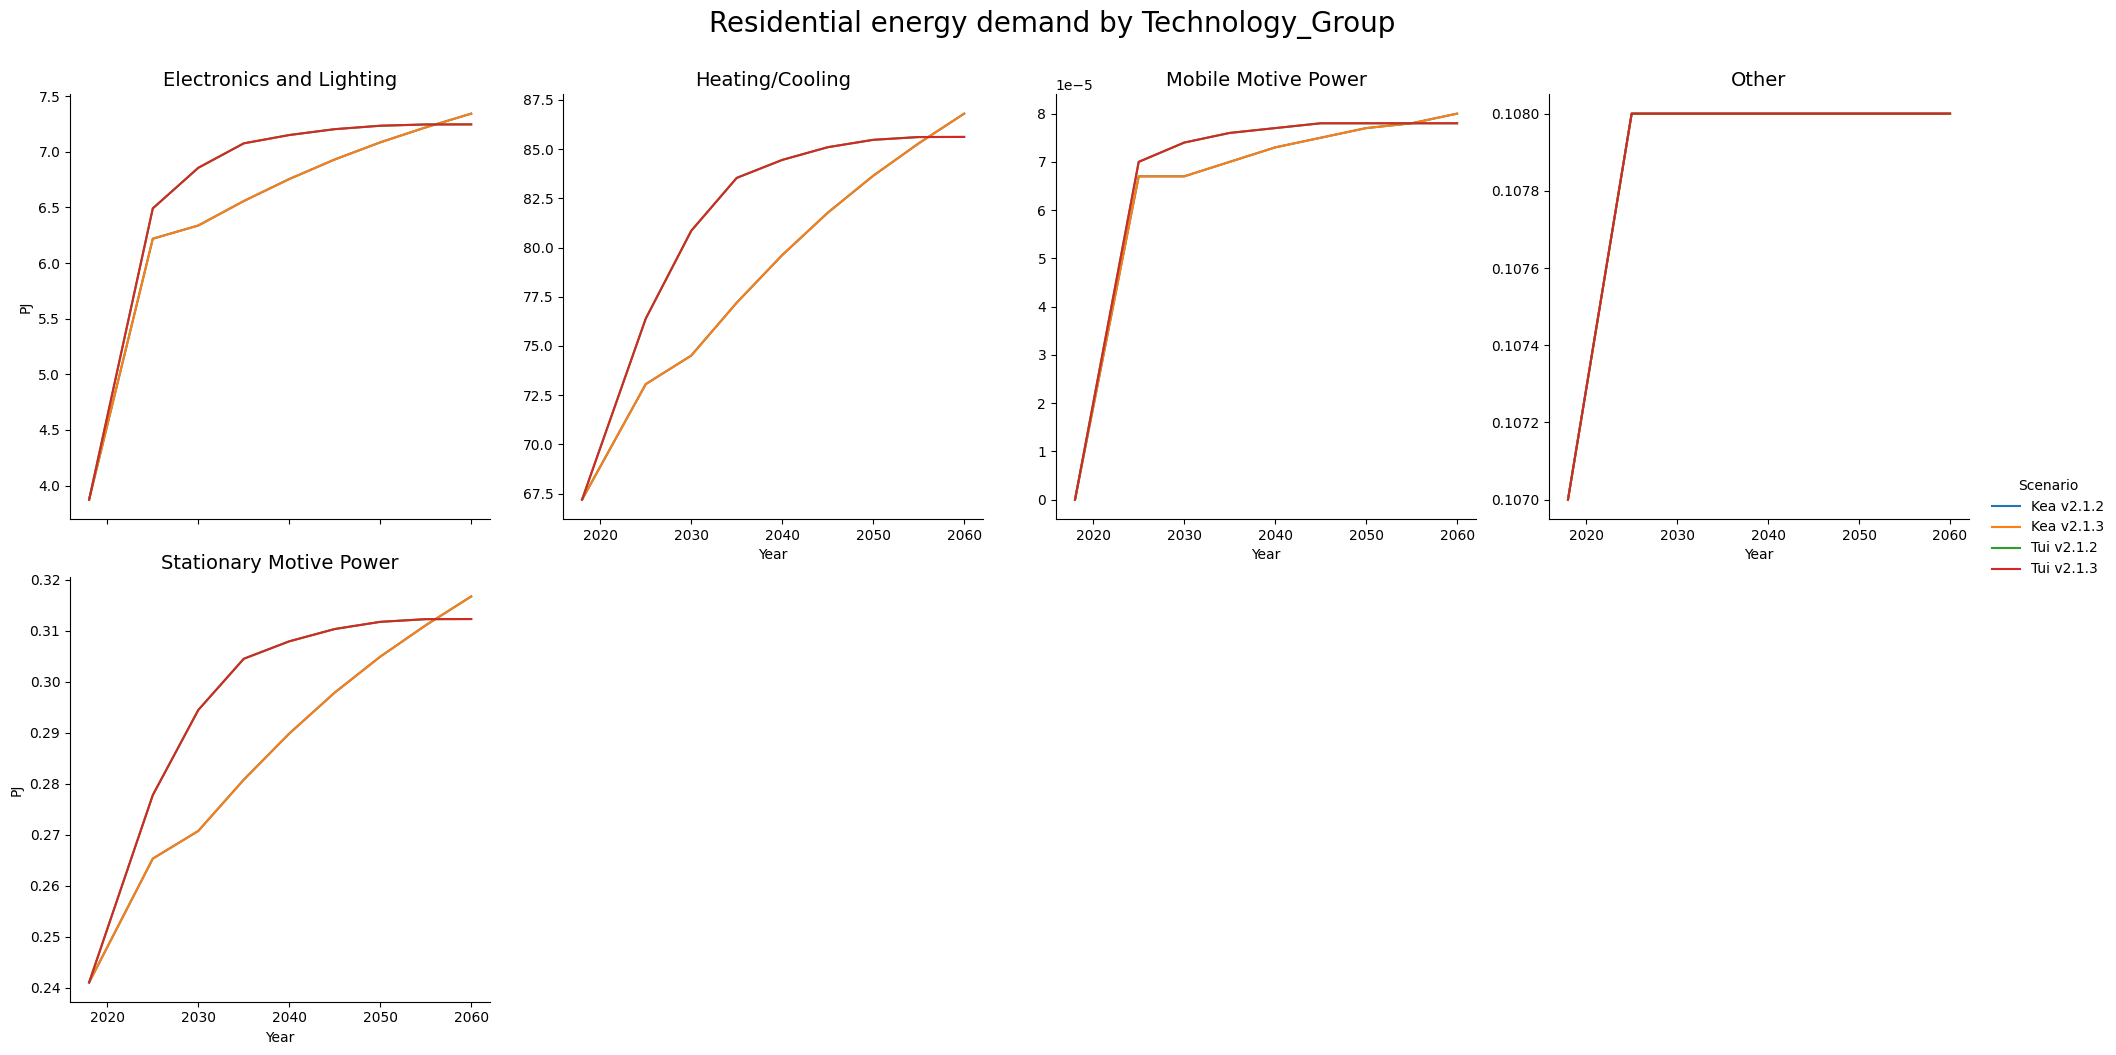

In [123]:
make_sector_demand_charts("Residential")

In [ ]:
make_sector_demand_charts("Transport")

want ESD (ie control for the efficiency of fuel used) so we can get the purest form of activity demand

then we would see how that is serviced just to get a better intuition 

for now a better approach might be to get a technology group X fuel split? 

## Generation

## Prices